# Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

C:\Users\THO NGUYEN\AppData\Local\Temp\ipykernel_10272\3734276146.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [2]:
company = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start, end)

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2012 entries, 2012-01-03 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2012 non-null   float64
 1   High       2012 non-null   float64
 2   Low        2012 non-null   float64
 3   Close      2012 non-null   float64
 4   Adj Close  2012 non-null   float64
 5   Volume     2012 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB


# Preparing Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []


for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x - prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(x_train, y_train, epochs=25, batch_size=32)





Epoch 1/25

61/61 [==============================] - 6s 32ms/step - loss: 0.0114
Epoch 2/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0026
Epoch 3/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0020
Epoch 4/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0020
Epoch 5/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0019
Epoch 6/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0017
Epoch 7/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0017
Epoch 8/25
61/61 [==============================] - 2s 37ms/step - loss: 0.0015
Epoch 9/25
61/61 [==============================] - 2s 35ms/step - loss: 0.0017
Epoch 10/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0014
Epoch 11/25
61/61 [==============================] - 2s 41ms/step - loss: 0.0013
Epoch 12/25
61/61 [==============================] - 2s 39ms/step - loss: 0.0013
Epoch 13/25
61/61 [===============

# Testing the Accuracy

In [6]:
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [7]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

33/33 [==============================] - 1s 11ms/step


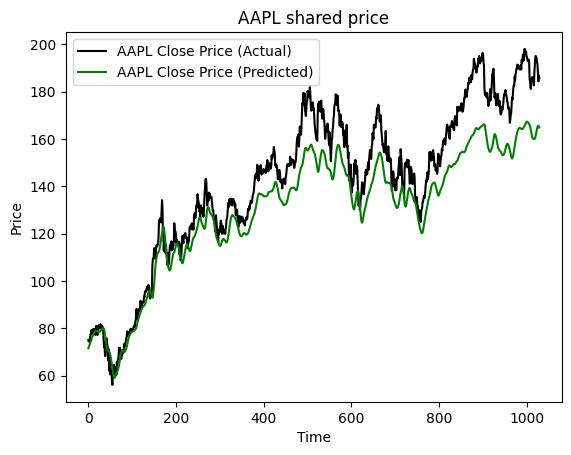

In [8]:
plt.plot(actual_prices, c="black", label = f"{company} Close Price (Actual)")
plt.plot(predicted_prices, c="green", label = f"{company} Close Price (Predicted)")
plt.legend()
plt.title(f"{company} shared price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# Make prediction

In [9]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")


1/1 [==============================] - 1s 859ms/step
Prediction: [[164.27603]]
